## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
!nvidia-smi

Thu Aug 20 13:42:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restore model weights

In [ ]:
!wget https://github.com/ariG23498/G-SimCLR/releases/download/v3.0/ImageNet_Subset_Deep_Autoencoder.zip
!unzip -qq ImageNet_Subset_Deep_Autoencoder.zip

In [ ]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  6%|▌         | 15/250 [00:00<00:01, 141.31it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 187.50it/s]


(250, 224, 224, 3) (250,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('ImageNet_Subset_Deep_Autoencoder/gsimclr_imagenet_subset_deep_ae.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [ ]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [ ]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [ ]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [ ]:
# These layers won't be trained as well
resnet_simclr.layers[3].trainable = False
resnet_simclr.layers[5].trainable = False

# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

Epoch 1/100
20/20 [==============================] - 0s 11ms/step - loss: 3.7586 - accuracy: 0.2048 - val_loss: 2.9451 - val_accuracy: 0.2440
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 2.6330 - accuracy: 0.2400 - val_loss: 2.0961 - val_accuracy: 0.2920
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1.9140 - accuracy: 0.3304 - val_loss: 1.6034 - val_accuracy: 0.4040
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 1.5106 - accuracy: 0.4232 - val_loss: 1.3791 - val_accuracy: 0.4520
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 1.3199 - accuracy: 0.4864 - val_loss: 1.2810 - val_accuracy: 0.5080
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 1.2352 - accuracy: 0.5088 - val_loss: 1.2354 - val_accuracy: 0.5040
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 1.1825 - accuracy: 0.5208 - val_loss: 1.2138 - val_accuracy: 0.5120
Epoch 8/100


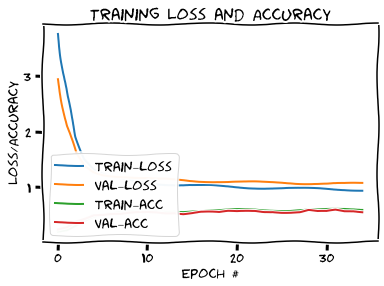

In [ ]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [ ]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
Total params: 24,112,256
Trainable params: 0
Non-trainable params: 24,112,256
_________________________________________________________________
None
(1250, 256) (250, 256)


Epoch 1/35
20/20 [==============================] - 0s 9ms/step - loss: 2.8088 - accuracy: 0.3000 - val_loss: 1.8602 - val_accuracy: 0.3760
Epoch 2/35
20/20 [==============================] - 0s 4ms/step - loss: 1.6417 - accuracy: 0.3952 - val_loss: 1.3419 - val_accuracy: 0.5520
Epoch 3/35
20/20 [==============================] - 0s 3ms/step - loss: 1.2997 - accuracy: 0.4872 - val_loss: 1.1965 - val_accuracy: 0.5440
Epoch 4/35
20/20 [==============================] - 0s 3ms/step - loss: 1.1920 - accuracy: 0.5064 - val_loss: 1.1455 - val_accuracy: 0.5480
Epoch 5/35
20/20 [==============================] - 0s 3ms/step - loss: 1.1443 - accuracy: 0.5288 - val_loss: 1.1205 - val_accuracy: 0.5440
Epoch 6/35
20/20 [==============================] - 0s 4ms/step - loss: 1.1179 - accuracy: 0.5344 - val_loss: 1.1037 - val_accuracy: 0.5440
Epoch 7/35
20/20 [==============================] - 0s 3ms/step - loss: 1.0883 - accuracy: 0.5464 - val_loss: 1.0909 - val_accuracy: 0.5600
Epoch 8/35
20/20 [==

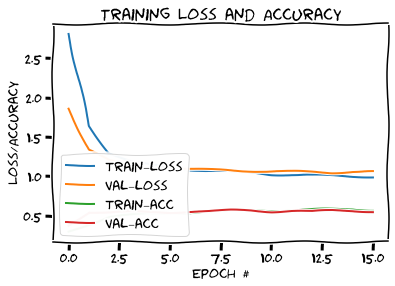

In [ ]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [ ]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
None
(1250, 2048) (250, 2048)


Epoch 1/35
20/20 [==============================] - 0s 9ms/step - loss: 1.6149 - accuracy: 0.4104 - val_loss: 1.0721 - val_accuracy: 0.5920
Epoch 2/35
20/20 [==============================] - 0s 4ms/step - loss: 1.1253 - accuracy: 0.5504 - val_loss: 1.1581 - val_accuracy: 0.5440
Epoch 3/35
20/20 [==============================] - 0s 4ms/step - loss: 1.0561 - accuracy: 0.5544 - val_loss: 1.0112 - val_accuracy: 0.6040
Epoch 4/35
20/20 [==============================] - 0s 4ms/step - loss: 1.0136 - accuracy: 0.5808 - val_loss: 1.0193 - val_accuracy: 0.5640
Epoch 5/35
20/20 [==============================] - 0s 4ms/step - loss: 0.9950 - accuracy: 0.5936 - val_loss: 1.0229 - val_accuracy: 0.5720
Epoch 00005: early stopping


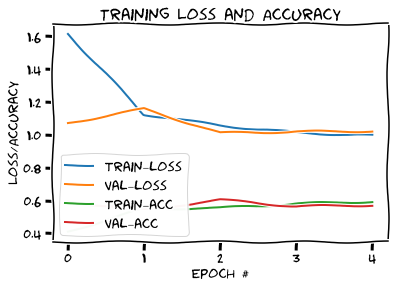

In [ ]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)